In [1]:
import warnings
from math import sqrt
import pandas as pd
import numpy as np
from pandas import read_csv, read_excel
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

Data: https://data.unicef.org/topic/child-survival/under-five-mortality/

In [2]:
def train_test_split(df):
    # prepare training dataset
    train, test= np.split(df, [int(.9 * len(df))])
    
    # defining X and y for model training and test
    X_train = train['value'].values.reshape(-1, 1)
    X_train = pd.DataFrame(X_train, columns = ['value'])
    y_train = train['year']
    
    # defining X and y for model training and test
    X_test = test['value'].values.reshape(-1, 1)
    y_test = test['year']
    
    max_train = y_train.max()
    min_train = y_train.min()

    max_test = y_test.max()
    min_test = y_test.min()
    return X_train, y_train, X_test, y_test, max_train, max_test, min_train, min_test

In [3]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X_train, X_test, max_train, max_test, min_train, min_test, arima_order):
    
    X_train.index = pd.date_range(start=f"'{min_train}'", end=f"'{max_train+1}'", freq='A')
    
    model = ARIMA(X_train.value, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.get_prediction(start=f"'{min_test}'", end=f"'{max_test}'")
    mean = yhat.predicted_mean
    summary = yhat.summary_frame()
#     print(model_fit.summary())
#     print(summary)
#     print(arima_order)
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(X_test, mean))
    aic = model_fit.aic

    return aic, rmse, summary, model_fit

In [4]:
def check_stationarity(df, col):

    stationary_data = df.copy()
    
    print(" > Is the data stationary ?")
    dftest = adfuller(df[col], autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

    stationary_data['z_data'] = (stationary_data[col] - stationary_data[col].rolling(window=12).mean()) / stationary_data[col].rolling(window=12).std()
    stationary_data['zp_data'] = stationary_data['z_data'] - stationary_data['z_data'].shift(12)
    stationary_data['one_diff_data'] = stationary_data[col].diff()
    stationary_data['two_diff_data'] = stationary_data[col].diff().diff()
    stationary_data['three_diff_data'] = stationary_data[col].diff().diff().diff()
    
    print("\n > Is the de-trended data stationary ?")
    dftest2 = adfuller(stationary_data.z_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest2[0]))
    print("P-value = {:.3f}".format(dftest2[1]))
    print("Critical values :")
    for k, v in dftest2[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest2[0] else "", 100-int(k[:-1])))

    print("\n > Is the 12-lag differenced de-trended data stationary ?")
    dftest3 = adfuller(stationary_data.zp_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest3[0]))
    print("P-value = {:.3f}".format(dftest3[1]))
    print("Critical values :")
    for k, v in dftest3[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest3[0] else "", 100-int(k[:-1])))
        
    print("\n > Is the first difference data stationary ?")
    dftest4 = adfuller(stationary_data['one_diff_data'].dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest4[0]))
    print("P-value = {:.3f}".format(dftest4[1]))
    print("Critical values :")
    for k, v in dftest4[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest4[0] else "", 100-int(k[:-1])))

    print("\n > Is the second difference data stationary ?")
    dftest5 = adfuller(stationary_data['two_diff_data'].dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest5[0]))
    print("P-value = {:.3f}".format(dftest5[1]))
    print("Critical values :")
    for k, v in dftest5[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest5[0] else "", 100-int(k[:-1])))

    print("\n > Is the third difference data stationary ?")
    dftest6 = adfuller(stationary_data['three_diff_data'].dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest6[0]))
    print("P-value = {:.3f}".format(dftest6[1]))
    print("Critical values :")
    for k, v in dftest6[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest6[0] else "", 100-int(k[:-1])))
        
        
    if list(dftest[4].values())[0] < dftest[0]:
        d=0
#     elif list(dftest2[4].values())[1] < dftest2[0]:
#         stationary_data["value"] = stationary_data['z_data']
#         return stationary_data
#     elif list(dftest3[4].values())[1] < dftest3[0]:
#         stationary_data["value"] = stationary_data['zp_data']
#         return stationary_data
    elif list(dftest4[4].values())[0] < dftest4[0]:
        d=1
    elif list(dftest5[4].values())[0] < dftest5[0]:
        d=2
    elif list(dftest6[4].values())[0] < dftest6[0]:
        d=3
    else:
        d=0
    return d

In [5]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values, country, max_pred):
    
    results = []
    aics = []
    rmses = []
    X_tests = []
    y_tests = []
    orders = []
    max_trains = [] 
    max_tests = [] 
    min_trains = []
    min_tests = []
    X_trains = []
    models = []
    forecasts = []
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    X_train, y_train, X_test, y_test, max_train, max_test, min_train, min_test = train_test_split(dataset)
                    aic, rmse, summary, model_fit= evaluate_arima_model(X_train, X_test, max_train, max_test, min_train, min_test, order)  
                    yhat = model_fit.get_prediction(start=f"'{max_test+1}'", end=f"'{max_pred}'")
                    mean = yhat.predicted_mean
                    forecast = yhat.summary_frame()
                    forecasts.append(forecast)

                    results.append(summary)
                    aics.append(aic)
                    rmses.append(rmse)
                    X_trains.append(X_train)
                    X_tests.append(X_test)
                    y_tests.append(y_test)
                    orders.append(order)
                    max_trains.append(max_train) 
                    max_tests.append(max_test) 
                    min_trains.append(min_train) 
                    min_tests.append(min_test)
                    models.append(model_fit)
                except:
                    continue
                    
    return results, aics, rmses, X_tests, y_tests, orders, max_tests, forecasts

In [6]:
# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

In [8]:
series = pd.read_excel('./data/Under-five_Mortality_Rates_2022.xlsx', sheet_name="raw_data", header=1)

In [9]:
df_transform = pd.melt(series, id_vars=["ISO.Code", "Country.Name", "Location.Type", "Uncertainty.Bounds*"], 
                       value_vars=series.columns[1:]).rename(columns={"variable":"year"})

In [10]:
df_transform["date"] = pd.to_datetime(df_transform['year'], format='%Y.%m')
df_transform["year"] = df_transform["date"].dt.year

In [11]:
analysis_df = df_transform[df_transform["Uncertainty.Bounds*"] == "Median"].reset_index().drop(columns="index")[["Country.Name", "Location.Type", "year", "value"]]

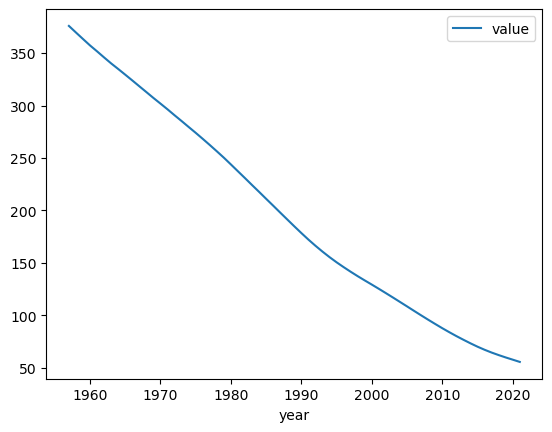

Afghanistan
 > Is the data stationary ?
Test statistic = -1.876
P-value = 0.344
Critical values :
	1%: -3.542412746661615 - The data is not stationary with 99% confidence
	5%: -2.910236235808284 - The data is not stationary with 95% confidence
	10%: -2.5927445767266866 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -1.167
P-value = 0.688
Critical values :
	1%: -3.596635636000432 - The data is not stationary with 99% confidence
	5%: -2.933297331821618 - The data is not stationary with 95% confidence
	10%: -2.6049909750566895 - The data is not stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -7.278
P-value = 0.000
Critical values :
	1%: -3.6055648906249997 - The data is  stationary with 99% confidence
	5%: -2.937069375 - The data is  stationary with 95% confidence
	10%: -2.606985625 - The data is  stationary with 90% confidence

 > Is the first difference data stationary ?

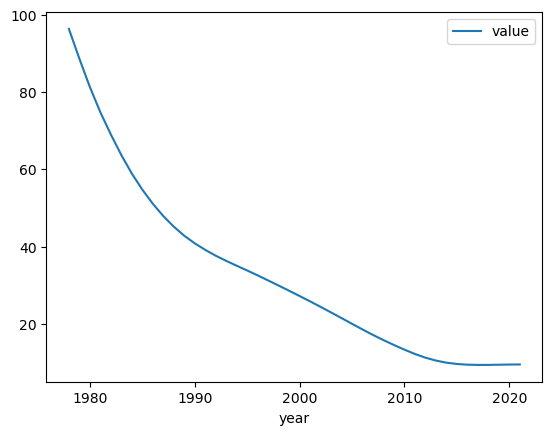

Albania
 > Is the data stationary ?
Test statistic = -3.831
P-value = 0.003
Critical values :
	1%: -3.639224104416853 - The data is  stationary with 99% confidence
	5%: -2.9512301791166293 - The data is  stationary with 95% confidence
	10%: -2.614446989619377 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -4.580
P-value = 0.000
Critical values :
	1%: -3.769732625845229 - The data is  stationary with 99% confidence
	5%: -3.005425537190083 - The data is  stationary with 95% confidence
	10%: -2.6425009917355373 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -2.407
P-value = 0.140
Critical values :
	1%: -3.9644434814814815 - The data is not stationary with 99% confidence
	5%: -3.0849081481481484 - The data is not stationary with 95% confidence
	10%: -2.6818144444444445 - The data is not stationary with 90% confidence

 > Is the first difference data stationary 

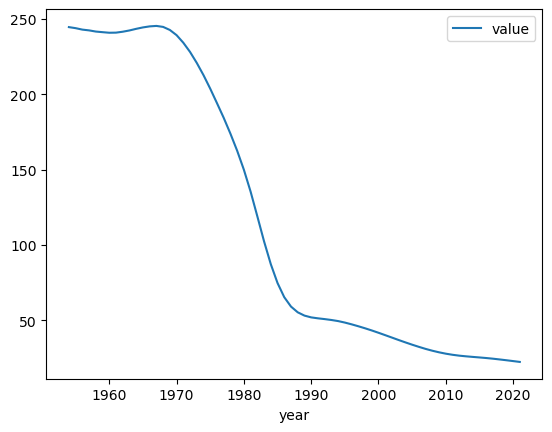

Algeria
 > Is the data stationary ?
Test statistic = -1.786
P-value = 0.388
Critical values :
	1%: -3.53692771987915 - The data is not stationary with 99% confidence
	5%: -2.907887369384766 - The data is not stationary with 95% confidence
	10%: -2.591493291015625 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -3.186
P-value = 0.021
Critical values :
	1%: -3.5778480370438146 - The data is not stationary with 99% confidence
	5%: -2.925338105429433 - The data is  stationary with 95% confidence
	10%: -2.6007735310095064 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -3.261
P-value = 0.017
Critical values :
	1%: -3.639224104416853 - The data is not stationary with 99% confidence
	5%: -2.9512301791166293 - The data is  stationary with 95% confidence
	10%: -2.614446989619377 - The data is  stationary with 90% confidence

 > Is the first difference data stationa

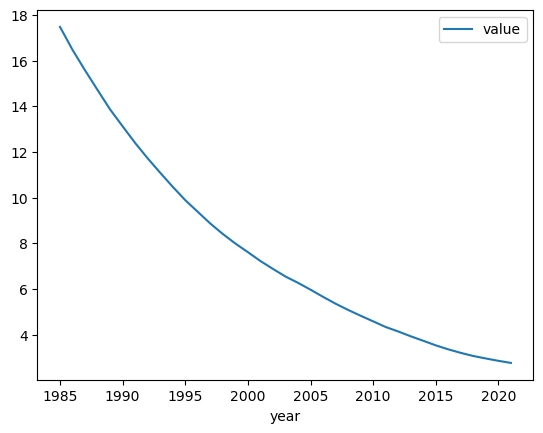

Andorra
 > Is the data stationary ?
Test statistic = -4.087
P-value = 0.001
Critical values :
	1%: -3.6327426647230316 - The data is  stationary with 99% confidence
	5%: -2.9485102040816327 - The data is  stationary with 95% confidence
	10%: -2.6130173469387756 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -0.948
P-value = 0.772
Critical values :
	1%: -3.7377092158564813 - The data is not stationary with 99% confidence
	5%: -2.9922162731481485 - The data is not stationary with 95% confidence
	10%: -2.635746736111111 - The data is not stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = 0.023
P-value = 0.960
Critical values :
	1%: -4.6651863281249994 - The data is not stationary with 99% confidence
	5%: -3.3671868750000002 - The data is not stationary with 95% confidence
	10%: -2.802960625 - The data is not stationary with 90% confidence

 > Is the first difference data station

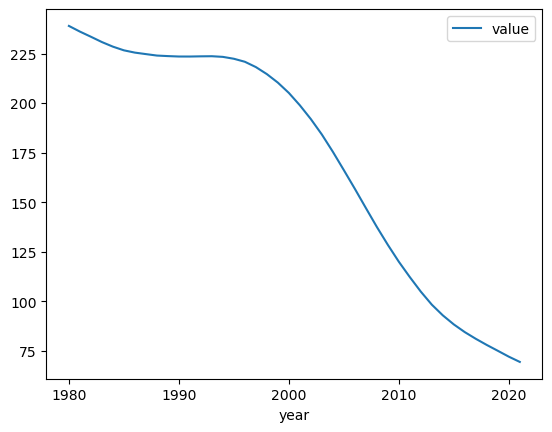

Angola
 > Is the data stationary ?
Test statistic = 2.927
P-value = 1.000
Critical values :
	1%: -3.6461350877925254 - The data is not stationary with 99% confidence
	5%: -2.954126991123355 - The data is not stationary with 95% confidence
	10%: -2.6159676124885216 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -1.459
P-value = 0.554
Critical values :
	1%: -3.7529275211638033 - The data is not stationary with 99% confidence
	5%: -2.998499866852963 - The data is not stationary with 95% confidence
	10%: -2.6389669754253307 - The data is not stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = 7.106
P-value = 1.000
Critical values :
	1%: -4.137829282407408 - The data is not stationary with 99% confidence
	5%: -3.1549724074074077 - The data is not stationary with 95% confidence
	10%: -2.7144769444444443 - The data is not stationary with 90% confidence

 > Is the first difference 

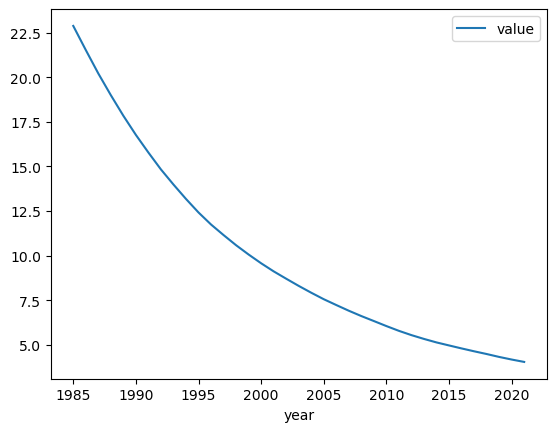

Anguilla
 > Is the data stationary ?
Test statistic = -3.141
P-value = 0.024
Critical values :
	1%: -3.6327426647230316 - The data is not stationary with 99% confidence
	5%: -2.9485102040816327 - The data is  stationary with 95% confidence
	10%: -2.6130173469387756 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -2.754
P-value = 0.065
Critical values :
	1%: -3.7377092158564813 - The data is not stationary with 99% confidence
	5%: -2.9922162731481485 - The data is not stationary with 95% confidence
	10%: -2.635746736111111 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -2.927
P-value = 0.042
Critical values :
	1%: -4.137829282407408 - The data is not stationary with 99% confidence
	5%: -3.1549724074074077 - The data is not stationary with 95% confidence
	10%: -2.7144769444444443 - The data is  stationary with 90% confidence

 > Is the first difference data st

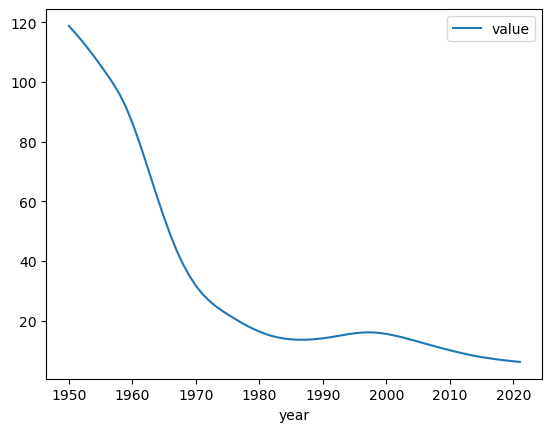

Antigua and Barbuda
 > Is the data stationary ?
Test statistic = -1.102
P-value = 0.714
Critical values :
	1%: -3.5443688564814813 - The data is not stationary with 99% confidence
	5%: -2.9110731481481484 - The data is not stationary with 95% confidence
	10%: -2.5931902777777776 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -3.039
P-value = 0.031
Critical values :
	1%: -3.5506699942762414 - The data is not stationary with 99% confidence
	5%: -2.913766394626147 - The data is  stationary with 95% confidence
	10%: -2.5946240473991997 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -2.925
P-value = 0.042
Critical values :
	1%: -3.584828853223594 - The data is not stationary with 99% confidence
	5%: -2.9282991495198907 - The data is not stationary with 95% confidence
	10%: -2.6023438271604937 - The data is  stationary with 90% confidence

 > Is the first diff

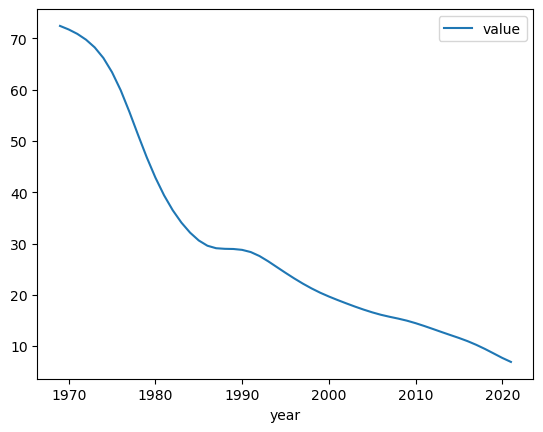

Argentina
 > Is the data stationary ?
Test statistic = -0.978
P-value = 0.761
Critical values :
	1%: -3.5925042342183704 - The data is not stationary with 99% confidence
	5%: -2.931549768951162 - The data is not stationary with 95% confidence
	10%: -2.60406594375338 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -3.492
P-value = 0.008
Critical values :
	1%: -3.626651907578875 - The data is not stationary with 99% confidence
	5%: -2.9459512825788754 - The data is  stationary with 95% confidence
	10%: -2.6116707716049383 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -3.575
P-value = 0.006
Critical values :
	1%: -3.8092091249999998 - The data is not stationary with 99% confidence
	5%: -3.0216450000000004 - The data is  stationary with 95% confidence
	10%: -2.6507125 - The data is  stationary with 90% confidence

 > Is the first difference data stationary ?

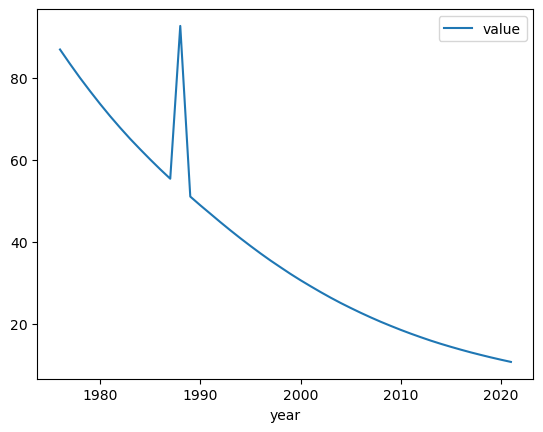

Armenia
 > Is the data stationary ?
Test statistic = -1.805
P-value = 0.378
Critical values :
	1%: -3.596635636000432 - The data is not stationary with 99% confidence
	5%: -2.933297331821618 - The data is not stationary with 95% confidence
	10%: -2.6049909750566895 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -7.582
P-value = 0.000
Critical values :
	1%: -3.7377092158564813 - The data is  stationary with 99% confidence
	5%: -2.9922162731481485 - The data is  stationary with 95% confidence
	10%: -2.635746736111111 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -5.744
P-value = 0.000
Critical values :
	1%: -3.769732625845229 - The data is  stationary with 99% confidence
	5%: -3.005425537190083 - The data is  stationary with 95% confidence
	10%: -2.6425009917355373 - The data is  stationary with 90% confidence

 > Is the first difference data stationary ?

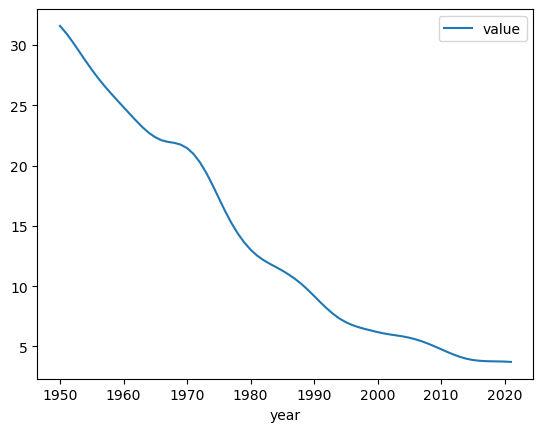

Australia
 > Is the data stationary ?
Test statistic = -1.703
P-value = 0.429
Critical values :
	1%: -3.5443688564814813 - The data is not stationary with 99% confidence
	5%: -2.9110731481481484 - The data is not stationary with 95% confidence
	10%: -2.5931902777777776 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -1.528
P-value = 0.520
Critical values :
	1%: -3.5714715250448363 - The data is not stationary with 99% confidence
	5%: -2.922629480573571 - The data is not stationary with 95% confidence
	10%: -2.5993358475635153 - The data is not stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -1.493
P-value = 0.537
Critical values :
	1%: -3.610399601308181 - The data is not stationary with 99% confidence
	5%: -2.939108945868946 - The data is not stationary with 95% confidence
	10%: -2.6080629651545038 - The data is not stationary with 90% confidence

 > Is the first differ

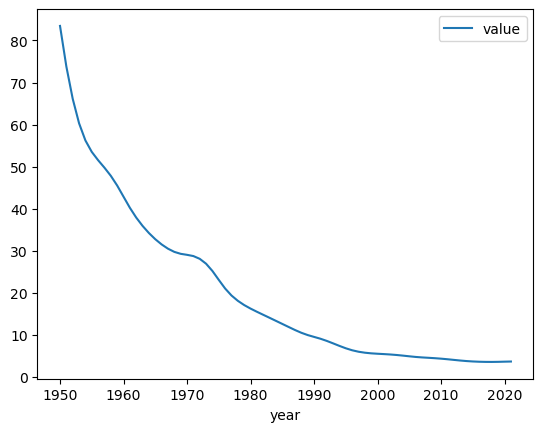

Austria
 > Is the data stationary ?
Test statistic = -2.999
P-value = 0.035
Critical values :
	1%: -3.5352168748293127 - The data is not stationary with 99% confidence
	5%: -2.9071540828402367 - The data is  stationary with 95% confidence
	10%: -2.5911025443786984 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -2.134
P-value = 0.231
Critical values :
	1%: -3.5552728880540942 - The data is not stationary with 99% confidence
	5%: -2.9157312396694217 - The data is not stationary with 95% confidence
	10%: -2.5956695041322315 - The data is not stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -2.912
P-value = 0.044
Critical values :
	1%: -3.5925042342183704 - The data is not stationary with 99% confidence
	5%: -2.931549768951162 - The data is not stationary with 95% confidence
	10%: -2.60406594375338 - The data is  stationary with 90% confidence

 > Is the first difference data s

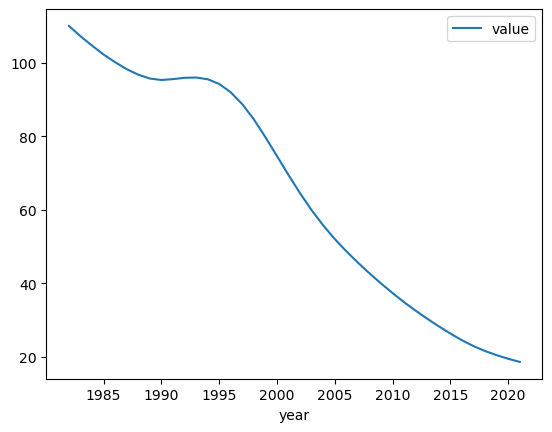

Azerbaijan
 > Is the data stationary ?
Test statistic = -4.073
P-value = 0.001
Critical values :
	1%: -3.6790595944893187 - The data is  stationary with 99% confidence
	5%: -2.9678817237279103 - The data is  stationary with 95% confidence
	10%: -2.6231583472057074 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -0.388
P-value = 0.912
Critical values :
	1%: -3.8326031418574136 - The data is not stationary with 99% confidence
	5%: -3.0312271701414204 - The data is not stationary with 95% confidence
	10%: -2.655519584487535 - The data is not stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -3.714
P-value = 0.004
Critical values :
	1%: -4.331573 - The data is not stationary with 99% confidence
	5%: -3.23295 - The data is  stationary with 95% confidence
	10%: -2.7487 - The data is  stationary with 90% confidence

 > Is the first difference data stationary ?
Test statistic = -1.17

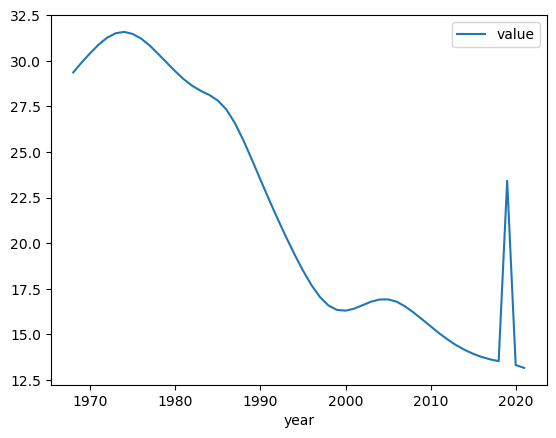

Bahamas
 > Is the data stationary ?
Test statistic = -1.470
P-value = 0.548
Critical values :
	1%: -3.5714715250448363 - The data is not stationary with 99% confidence
	5%: -2.922629480573571 - The data is not stationary with 95% confidence
	10%: -2.5993358475635153 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -3.824
P-value = 0.003
Critical values :
	1%: -3.596635636000432 - The data is  stationary with 99% confidence
	5%: -2.933297331821618 - The data is  stationary with 95% confidence
	10%: -2.6049909750566895 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -2.789
P-value = 0.060
Critical values :
	1%: -3.6699197407407405 - The data is not stationary with 99% confidence
	5%: -2.9640707407407407 - The data is not stationary with 95% confidence
	10%: -2.621171111111111 - The data is  stationary with 90% confidence

 > Is the first difference data stati

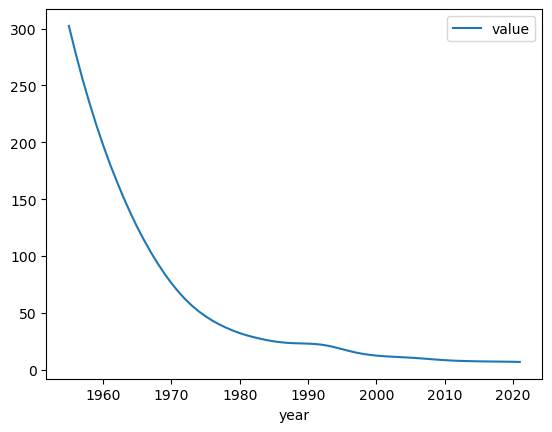

Bahrain
 > Is the data stationary ?
Test statistic = -2.901
P-value = 0.045
Critical values :
	1%: -3.548493559596539 - The data is not stationary with 99% confidence
	5%: -2.912836594776334 - The data is not stationary with 95% confidence
	10%: -2.594129155766944 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -2.096
P-value = 0.246
Critical values :
	1%: -3.5714715250448363 - The data is not stationary with 99% confidence
	5%: -2.922629480573571 - The data is not stationary with 95% confidence
	10%: -2.5993358475635153 - The data is not stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -2.893
P-value = 0.046
Critical values :
	1%: -3.6155091011809297 - The data is not stationary with 99% confidence
	5%: -2.941262357486514 - The data is not stationary with 95% confidence
	10%: -2.6091995013850418 - The data is  stationary with 90% confidence

 > Is the first difference data 

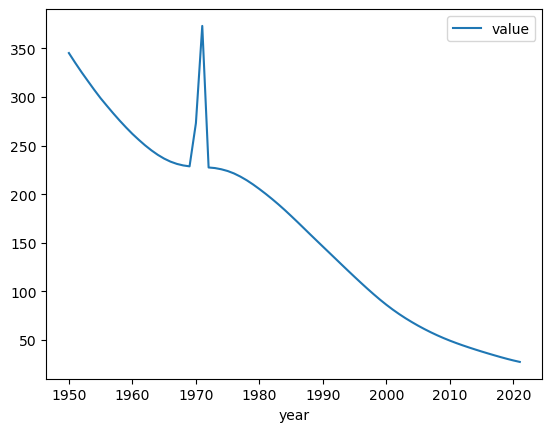

Bangladesh
 > Is the data stationary ?
Test statistic = -0.984
P-value = 0.759
Critical values :
	1%: -3.530398990560757 - The data is not stationary with 99% confidence
	5%: -2.9050874099328317 - The data is not stationary with 95% confidence
	10%: -2.5900010121107266 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -9.433
P-value = 0.000
Critical values :
	1%: -3.5714715250448363 - The data is  stationary with 99% confidence
	5%: -2.922629480573571 - The data is  stationary with 95% confidence
	10%: -2.5993358475635153 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -11.378
P-value = 0.000
Critical values :
	1%: -3.6209175221605827 - The data is  stationary with 99% confidence
	5%: -2.9435394610388332 - The data is  stationary with 95% confidence
	10%: -2.6104002410518627 - The data is  stationary with 90% confidence

 > Is the first difference data stati

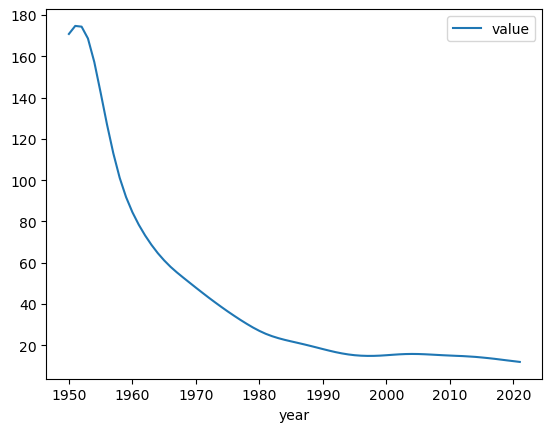

Barbados
 > Is the data stationary ?
Test statistic = -2.010
P-value = 0.282
Critical values :
	1%: -3.5443688564814813 - The data is not stationary with 99% confidence
	5%: -2.9110731481481484 - The data is not stationary with 95% confidence
	10%: -2.5931902777777776 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -2.851
P-value = 0.051
Critical values :
	1%: -3.560242358792829 - The data is not stationary with 99% confidence
	5%: -2.9178502070837 - The data is not stationary with 95% confidence
	10%: -2.5967964150943397 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -3.512
P-value = 0.008
Critical values :
	1%: -3.584828853223594 - The data is not stationary with 99% confidence
	5%: -2.9282991495198907 - The data is  stationary with 95% confidence
	10%: -2.6023438271604937 - The data is  stationary with 90% confidence

 > Is the first difference data st

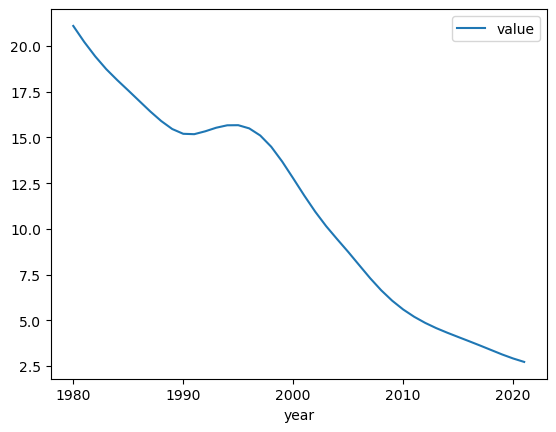

Belarus
 > Is the data stationary ?
Test statistic = -0.414
P-value = 0.908
Critical values :
	1%: -3.6461350877925254 - The data is not stationary with 99% confidence
	5%: -2.954126991123355 - The data is not stationary with 95% confidence
	10%: -2.6159676124885216 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -3.163
P-value = 0.022
Critical values :
	1%: -3.7883858816542486 - The data is not stationary with 99% confidence
	5%: -3.013097747543462 - The data is  stationary with 95% confidence
	10%: -2.6463967573696143 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -8.921
P-value = 0.000
Critical values :
	1%: -4.223238279489106 - The data is  stationary with 99% confidence
	5%: -3.189368925619835 - The data is  stationary with 95% confidence
	10%: -2.729839421487603 - The data is  stationary with 90% confidence

 > Is the first difference data stationar

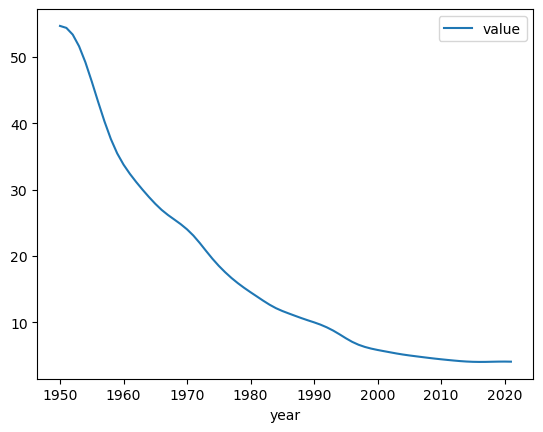

Belgium
 > Is the data stationary ?
Test statistic = -2.415
P-value = 0.138
Critical values :
	1%: -3.5463945337644063 - The data is not stationary with 99% confidence
	5%: -2.911939409384601 - The data is not stationary with 95% confidence
	10%: -2.5936515282964665 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -1.059
P-value = 0.731
Critical values :
	1%: -3.560242358792829 - The data is not stationary with 99% confidence
	5%: -2.9178502070837 - The data is not stationary with 95% confidence
	10%: -2.5967964150943397 - The data is not stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -2.116
P-value = 0.238
Critical values :
	1%: -3.5885733964124715 - The data is not stationary with 99% confidence
	5%: -2.929885661157025 - The data is not stationary with 95% confidence
	10%: -2.6031845661157025 - The data is not stationary with 90% confidence

 > Is the first difference 

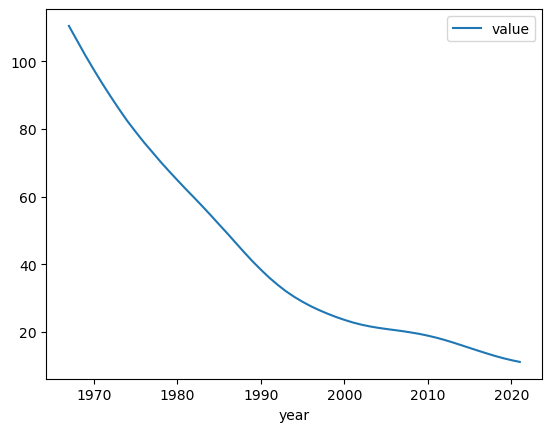

Belize
 > Is the data stationary ?
Test statistic = -3.465
P-value = 0.009
Critical values :
	1%: -3.5656240522121956 - The data is not stationary with 99% confidence
	5%: -2.920142229157715 - The data is  stationary with 95% confidence
	10%: -2.598014675124952 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -2.651
P-value = 0.083
Critical values :
	1%: -3.6327426647230316 - The data is not stationary with 99% confidence
	5%: -2.9485102040816327 - The data is not stationary with 95% confidence
	10%: -2.6130173469387756 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -3.804
P-value = 0.003
Critical values :
	1%: -3.7883858816542486 - The data is  stationary with 99% confidence
	5%: -3.013097747543462 - The data is  stationary with 95% confidence
	10%: -2.6463967573696143 - The data is  stationary with 90% confidence

 > Is the first difference data stationary 

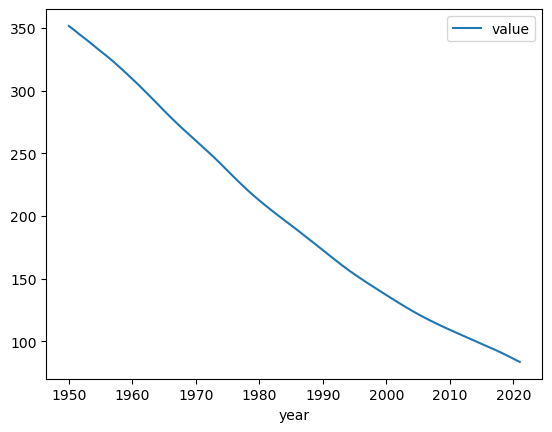

Benin
 > Is the data stationary ?
Test statistic = -3.898
P-value = 0.002
Critical values :
	1%: -3.53692771987915 - The data is  stationary with 99% confidence
	5%: -2.907887369384766 - The data is  stationary with 95% confidence
	10%: -2.591493291015625 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -3.041
P-value = 0.031
Critical values :
	1%: -3.548493559596539 - The data is not stationary with 99% confidence
	5%: -2.912836594776334 - The data is  stationary with 95% confidence
	10%: -2.594129155766944 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -1.548
P-value = 0.510
Critical values :
	1%: -3.5812576580093696 - The data is not stationary with 99% confidence
	5%: -2.9267849124681518 - The data is not stationary with 95% confidence
	10%: -2.6015409829867675 - The data is not stationary with 90% confidence

 > Is the first difference data stationary ?


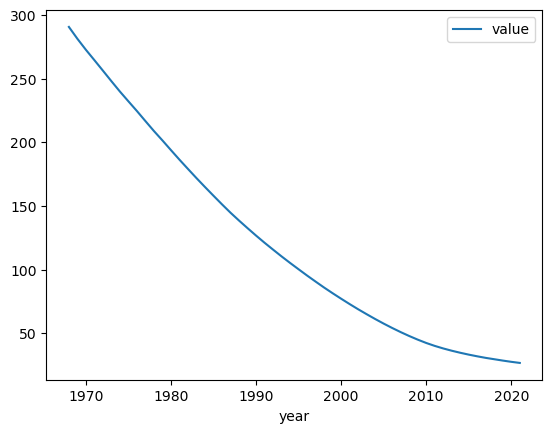

Bhutan
 > Is the data stationary ?
Test statistic = -2.391
P-value = 0.144
Critical values :
	1%: -3.5714715250448363 - The data is not stationary with 99% confidence
	5%: -2.922629480573571 - The data is not stationary with 95% confidence
	10%: -2.5993358475635153 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -2.821
P-value = 0.055
Critical values :
	1%: -3.60098336718852 - The data is not stationary with 99% confidence
	5%: -2.9351348158036012 - The data is not stationary with 95% confidence
	10%: -2.6059629803688282 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -3.245
P-value = 0.018
Critical values :
	1%: -3.6996079738860943 - The data is not stationary with 99% confidence
	5%: -2.9764303469999494 - The data is  stationary with 95% confidence
	10%: -2.627601001371742 - The data is  stationary with 90% confidence

 > Is the first difference data sta

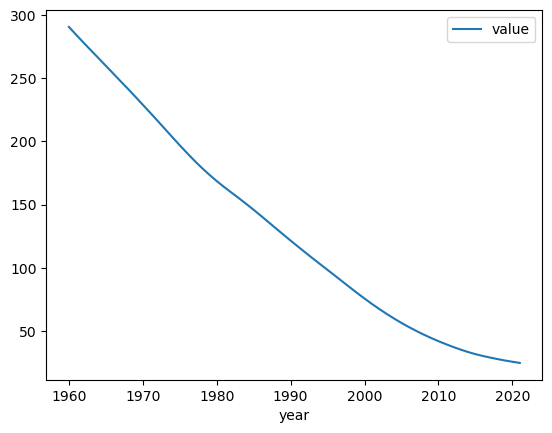

Bolivia (Plurinational State of)
 > Is the data stationary ?
Test statistic = -1.272
P-value = 0.642
Critical values :
	1%: -3.552928203580539 - The data is not stationary with 99% confidence
	5%: -2.9147306250000002 - The data is not stationary with 95% confidence
	10%: -2.595137155612245 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -0.096
P-value = 0.950
Critical values :
	1%: -3.5778480370438146 - The data is not stationary with 99% confidence
	5%: -2.925338105429433 - The data is not stationary with 95% confidence
	10%: -2.6007735310095064 - The data is not stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -4.086
P-value = 0.001
Critical values :
	1%: -3.6209175221605827 - The data is  stationary with 99% confidence
	5%: -2.9435394610388332 - The data is  stationary with 95% confidence
	10%: -2.6104002410518627 - The data is  stationary with 90% confidence

 > Is th

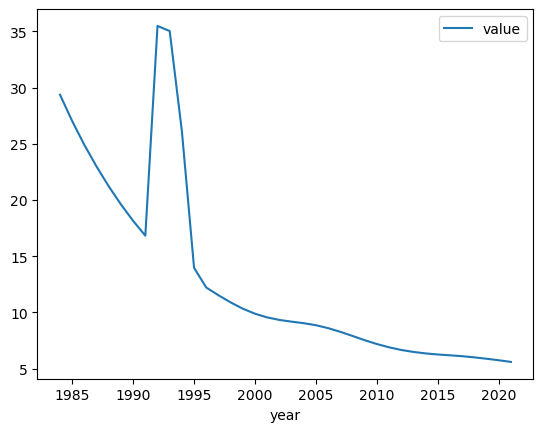

Bosnia and Herzegovina
 > Is the data stationary ?
Test statistic = -37.674
P-value = 0.000
Critical values :
	1%: -3.6790595944893187 - The data is  stationary with 99% confidence
	5%: -2.9678817237279103 - The data is  stationary with 95% confidence
	10%: -2.6231583472057074 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -2.601
P-value = 0.093
Critical values :
	1%: -3.7529275211638033 - The data is not stationary with 99% confidence
	5%: -2.998499866852963 - The data is not stationary with 95% confidence
	10%: -2.6389669754253307 - The data is not stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -1.187
P-value = 0.679
Critical values :
	1%: -4.01203360058309 - The data is not stationary with 99% confidence
	5%: -3.1041838775510207 - The data is not stationary with 95% confidence
	10%: -2.6909873469387753 - The data is not stationary with 90% confidence

 > Is the first d

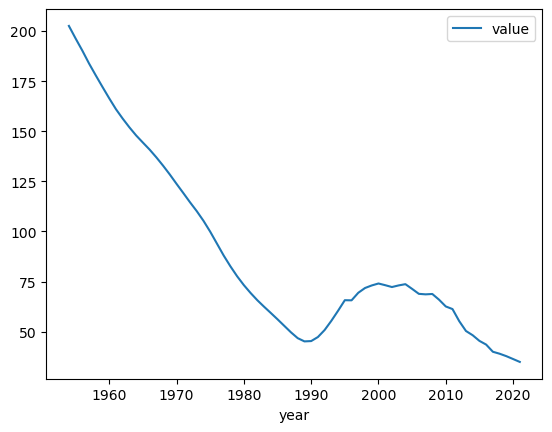

Botswana
 > Is the data stationary ?
Test statistic = -1.854
P-value = 0.354
Critical values :
	1%: -3.5352168748293127 - The data is not stationary with 99% confidence
	5%: -2.9071540828402367 - The data is not stationary with 95% confidence
	10%: -2.5911025443786984 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -2.800
P-value = 0.058
Critical values :
	1%: -3.560242358792829 - The data is not stationary with 99% confidence
	5%: -2.9178502070837 - The data is not stationary with 95% confidence
	10%: -2.5967964150943397 - The data is  stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -2.970
P-value = 0.038
Critical values :
	1%: -3.60098336718852 - The data is not stationary with 99% confidence
	5%: -2.9351348158036012 - The data is  stationary with 95% confidence
	10%: -2.6059629803688282 - The data is  stationary with 90% confidence

 > Is the first difference data sta

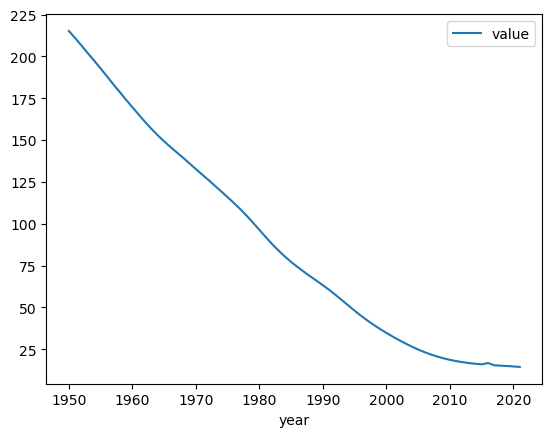

Brazil
 > Is the data stationary ?
Test statistic = -1.862
P-value = 0.350
Critical values :
	1%: -3.528889992207215 - The data is not stationary with 99% confidence
	5%: -2.9044395987933362 - The data is not stationary with 95% confidence
	10%: -2.589655654274312 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -1.400
P-value = 0.582
Critical values :
	1%: -3.5463945337644063 - The data is not stationary with 99% confidence
	5%: -2.911939409384601 - The data is not stationary with 95% confidence
	10%: -2.5936515282964665 - The data is not stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -1.819
P-value = 0.371
Critical values :
	1%: -3.5745892596209488 - The data is not stationary with 99% confidence
	5%: -2.9239543084490744 - The data is not stationary with 95% confidence
	10%: -2.6000391840277777 - The data is not stationary with 90% confidence

 > Is the first differenc

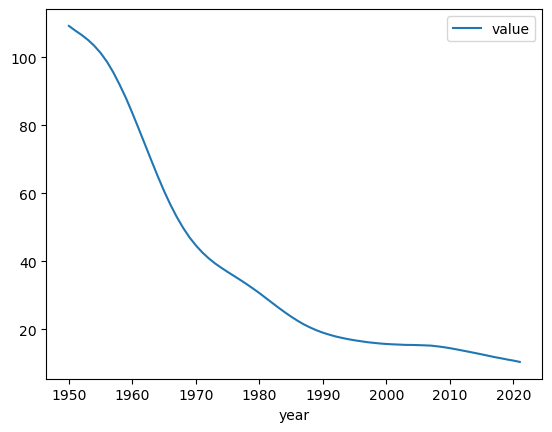

British Virgin Islands
 > Is the data stationary ?
Test statistic = -4.243
P-value = 0.001
Critical values :
	1%: -3.5352168748293127 - The data is  stationary with 99% confidence
	5%: -2.9071540828402367 - The data is  stationary with 95% confidence
	10%: -2.5911025443786984 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -2.567
P-value = 0.100
Critical values :
	1%: -3.548493559596539 - The data is not stationary with 99% confidence
	5%: -2.912836594776334 - The data is not stationary with 95% confidence
	10%: -2.594129155766944 - The data is not stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -3.283
P-value = 0.016
Critical values :
	1%: -3.5925042342183704 - The data is not stationary with 99% confidence
	5%: -2.931549768951162 - The data is  stationary with 95% confidence
	10%: -2.60406594375338 - The data is  stationary with 90% confidence

 > Is the first difference 

In [ ]:
country_name = analysis_df["Country.Name"].unique()

# country_name = ["World"]

test_results = []
final_results = []

max_pred = 2100

for x in country_name:
    df = analysis_df[analysis_df["Country.Name"] ==x]
    analysis_agg = df["Location.Type"]
    df = df[["year", "value"]].dropna()
    
    df.set_index("year").plot()
    plt.show()
    
    print(x)
#     print(df.sort_values(by="value", ascending=True))
    try:
        d = check_stationarity(df, "value")
    except:
        d=0
    # evaluate parameters
    p_values = [0, 1, 2, 3, 4, 6, 8, 10]
    d_values = range(d, 4)
    q_values = range(0, 4)
    warnings.filterwarnings("ignore")
    results, aics, rmses, X_tests, y_tests, orders, max_tests, forecasts = evaluate_models(df, p_values, d_values, q_values, x, max_pred)
    
    for result, aic, rmse, X_test, y_test, order in zip(results, aics, rmses, X_tests, y_tests, orders):
        summary =result.copy()
        summary["value"] = X_test
        summary["year"] = y_test
        summary["pdq"] = ''.join(map(str, order))
        summary["aic"] = aic
        summary["rmse"] = rmse
        summary["geo"] = x
        test_results.append(summary)

    for forecast, aic, rmse, X_test, y_test, order, max_test in zip(forecasts, aics, rmses, X_tests, y_tests, orders, max_tests):
        forecasted_results =forecast.copy()
        forecasted_results["year"] = pd.date_range(start=f"'{max_test+1}'", end=f"'{max_pred+1}'", freq='A')
        forecasted_results["pdq"] = ''.join(map(str, order))
        forecasted_results["geo"] = x
        final_results.append(forecasted_results)

In [ ]:
test_results_output = pd.concat(test_results, ignore_index=True, axis=0)
final_results_output = pd.concat(final_results, ignore_index=True, axis=0)

In [ ]:
test_results_output.to_csv("test_results_under5_mortality.csv")
final_results_output.to_csv("final_results_under5_mortality.csv")